<a href="https://colab.research.google.com/github/c-labropoulos/NN-for-lithological-segmentation/blob/main/toRaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
#!gdalinfo --version
!pip install geopandas
!pip install rasterio
!pip install pyshp
from osgeo import gdal
from osgeo import ogr
import rasterio
import geopandas as gpd
import shapefile as shp
import os
import matplotlib.pyplot as plt
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 24.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 2.1 MB/s eta 0:00:00


In [5]:
def labelcreation(folder_path):
  unique_labels = set()
  for file_name in os.listdir(folder_path):
    if file_name.endswith(".shp"):
        file_path = os.path.join(folder_path, file_name)
        gdf = gpd.read_file(file_path)
        labels = set(gdf["labels_Lit"]) # replace "label" with the name of the column containing the labels in your shapefile
        unique_labels = unique_labels.union(labels)
  label_dict = {i: label for i, label in enumerate(unique_labels)}
  
  return label_dict
folder_path = "/content/drive/MyDrive/LithDatasSHP"
unique_labels=labelcreation(folder_path)
print(unique_labels)

{0: nan, 1: 'Not available', 2: 'Psamitikos Flisxis', 3: 'Koites Potamon', 4: 'Tritogeneis apotheseis', 5: 'Konoi Apotheseon', 6: 'Kollouvia Flisxi', 7: 'Gnesioi', 8: 'Sxistolithoi', 9: 'Miktos Flisxis', 10: 'Kollouvia Asvestolithon', 11: 'Allouvia', 12: 'Peridotites kai Gavroi', 13: 'Skliroi asvestolithoi', 14: 'Dolites', 15: 'Granitis', 16: 'Kollouvia Gneusion', 17: 'Argilikos Flisxis kai Keratolithoi'}


In [6]:
def lists_for_rasterize(shppath, tiffpath):
    # Create empty lists to hold shapefile and raster file paths and names
    shape_files = []        
    shape_names = []       
    raster_files = []      
    raster_names = []     

    # Use os.walk() to recursively search shppath for shapefiles
    for dirpath, subdirs, files in os.walk(shppath):
        # Check each file in the current directory for the ".shp" extension
        for file in files:
            if file.endswith(".shp"):
                # If the file has the ".shp" extension, append its path and name to the shape_files and shape_names lists
                shape_files.append(os.path.join(dirpath, file))
                shape_names.append(file.split('.shp', 1)[0])

    # Use os.walk() to recursively search tiffpath for raster files
    for dirpath, subdirs, files in os.walk(tiffpath):
        # Check each file in the current directory for the ".tif" extension
        for file in files:
            if file.endswith(".tif"):
                # If the file has the ".tif" extension, append its path and name to the raster_files and raster_names lists
                raster_files.append(os.path.join(dirpath, file))
                raster_names.append(file.split('.tif', 1)[0])

    # Create a list of shapefile paths that correspond to each raster file in raster_names
    shapes_list = [None] * len(raster_names)  # Initialize shapes_list with None values
    for i, raster_name in enumerate(raster_names):
        # Find the shapefile that corresponds to the current raster file
        matching_shape = next((s for s in shape_files if raster_name in s), None)
        if matching_shape:
            # If a matching shapefile was found, append its path to shapes_list at the corresponding index
            shapes_list[i] = matching_shape
    shapes_list = [s for s in shapes_list if s]  # Remove any remaining None values from shapes_list

    # Return the lists of shapefile and raster file paths and names
    return shapes_list, raster_files, raster_names
 

In [7]:
def rasterize(shppath, tiffpath):
  # Get lists of shapefiles and corresponding raster files
  shplist, rasterlist, namesFORDESTINATION = lists_for_rasterize(shppath, tiffpath)
  # Create a dictionary of unique labels present in the shapefiles
  unique_labels = labelcreation(shppath)
  # Check if the number of shapefiles and raster files is the same
  filesnumber = 0
  if len(rasterlist) == len(shplist):
    filesnumber = len(shplist)
  else:
    print("SEVERE ERROR: raster list has length of " + str(len(rasterlist)) + " and shp files list has length " + str(len(shplist)))
  # Loop through each shapefile and corresponding raster file
  for i in range(filesnumber):
    # Open the raster file
    raster = rasterio.open(rasterlist[i])
    print("RASTER: " + str(rasterlist[i]) + " opened")
    # Open the shapefile
    vector = gpd.read_file(shplist[i])
    print("Vector: " + str(shplist[i]) + " opened")
    # Get a list of labels from the shapefile
    vectorlabels = list(vector['labels_Lit'])
    # Get a list of pixel values corresponding to the labels in the shapefile
    pixels = [key for key, value in unique_labels.items() if value in vectorlabels]
    print(len(pixels))
    print(pixels)
    print()
    # Create tuples of geometry, value pairs, where value is the attribute value you want to burn
    geom_value = ((geom, value) for geom, value in zip(vector.geometry, pixels))
    # Rasterize vector using the shape and transform of the raster
    rasterized = features.rasterize(geom_value, out_shape=raster.shape,
                                    transform=raster.transform,
                                    all_touched=True,
                                    merge_alg=MergeAlg.replace,
                                    dtype=np.int16)
    # Write the rasterized image to a new tiff file
    with rasterio.open("/content/drive/MyDrive/raster_to_be_used/" + namesFORDESTINATION[i] + "_rasterized_vector.tif", "w",
                       driver="GTiff",
                       transform=raster.transform,
                       dtype=rasterized.dtype,
                       count=1,
                       width=raster.width,
                       height=raster.height) as dst:
      dst.write(rasterized, indexes=1)

# Set the directories for shapefiles and raster files
shape_dir = "/content/drive/MyDrive/LithDatasSHP"
raster_dir = '/content/drive/MyDrive/LithDatasTIF'
# Call the rasterize function with the directories
rasterize(shape_dir, raster_dir)


RASTER: /content/drive/MyDrive/LithDatasTIF/Agios_Georgios.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Agios_Georgios.shp opened
5
[4, 8, 10, 11, 13]



RASTER: /content/drive/MyDrive/LithDatasTIF/Amfilochia.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Amfilochia.shp opened
5
[1, 4, 10, 13, 14]



RASTER: /content/drive/MyDrive/LithDatasTIF/Anafi.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Anafi.shp opened
4
[4, 5, 8, 15]



RASTER: /content/drive/MyDrive/LithDatasTIF/Crete_A.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Crete_A.shp opened
5
[4, 8, 9, 11, 13]



RASTER: /content/drive/MyDrive/LithDatasTIF/Crete_B.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Crete_B.shp opened
3
[4, 8, 13]



RASTER: /content/drive/MyDrive/LithDatasTIF/Desfina_B.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Desfina_B.shp opened
3
[6, 11, 13]



RASTER: /content/drive/MyDrive/LithDatasTIF/Ermoupoli.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Ermoupoli.shp opened
2
[8, 13]



RASTER: /content/drive/MyDrive/LithDatasTIF/Exarchos.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Exarchos.shp opened
6
[0, 4, 10, 11, 12, 13]



RASTER: /content/drive/MyDrive/LithDatasTIF/Grevena.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Grevena.shp opened
2
[4, 11]



RASTER: /content/drive/MyDrive/LithDatasTIF/Kastro.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Kastro.shp opened
3
[4, 11, 13]



RASTER: /content/drive/MyDrive/LithDatasTIF/Kimmeria.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Kimmeria.shp opened
6
[7, 9, 11, 12, 13, 15]



RASTER: /content/drive/MyDrive/LithDatasTIF/Kirko_Bunaras.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Kirko_Bunaras.shp opened
3
[4, 7, 15]



RASTER: /content/drive/MyDrive/LithDatasTIF/Kithnos_A.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Kithnos_A.shp opened
3
[8, 11, 13]



RASTER: /content/drive/MyDrive/LithDatasTIF/Kithnos_B.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Kithnos_B.shp opened
2
[8, 11]



RASTER: /content/drive/MyDrive/LithDatasTIF/Kyprios.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Kyprios.shp opened
4
[1, 4, 8, 11]



RASTER: /content/drive/MyDrive/LithDatasTIF/Lighurio.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Lighurio.shp opened
5
[4, 10, 11, 12, 13]



RASTER: /content/drive/MyDrive/LithDatasTIF/LIMENARIA.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/LIMENARIA.shp opened
5
[4, 7, 10, 11, 13]



RASTER: /content/drive/MyDrive/LithDatasTIF/Megara.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Megara.shp opened
3
[8, 10, 13]



RASTER: /content/drive/MyDrive/LithDatasTIF/Mesorrahi.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Mesorrahi.shp opened
4
[4, 8, 10, 13]



RASTER: /content/drive/MyDrive/LithDatasTIF/Metsitia_Arta.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Metsitia_Arta.shp opened
6
[5, 9, 10, 11, 13, 17]



RASTER: /content/drive/MyDrive/LithDatasTIF/Monopigado.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Monopigado.shp opened
4
[4, 8, 13, 15]



RASTER: /content/drive/MyDrive/LithDatasTIF/Neraidoxori.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Neraidoxori.shp opened
6
[3, 4, 9, 11, 13, 17]



RASTER: /content/drive/MyDrive/LithDatasTIF/Petroto.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Petroto.shp opened
8
[0, 7, 8, 10, 11, 13, 15, 16]



RASTER: /content/drive/MyDrive/LithDatasTIF/Skandalo.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Skandalo.shp opened
3
[8, 11, 13]



RASTER: /content/drive/MyDrive/LithDatasTIF/Tirnavos.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Tirnavos.shp opened
3
[10, 11, 13]



RASTER: /content/drive/MyDrive/LithDatasTIF/Voras.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Voras.shp opened
2
[7, 13]



RASTER: /content/drive/MyDrive/LithDatasTIF/XIOS.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/XIOS.shp opened
6
[1, 4, 8, 10, 11, 13]



RASTER: /content/drive/MyDrive/LithDatasTIF/naxos_corected.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/naxos_corected.shp opened
3
[8, 13, 15]



RASTER: /content/drive/MyDrive/LithDatasTIF/Velia.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Velia.shp opened
3
[4, 10, 13]



RASTER: /content/drive/MyDrive/LithDatasTIF/Desfina.tif opened
Vector: /content/drive/MyDrive/LithDatasSHP/Desfina.shp opened
3
[2, 11, 13]



This above  named "rasterize" function that takes two input arguments: a path to a shapefile (shppath) and a path to a GeoTIFF file (tiffpath). The function uses the rasterio and geopandas libraries to convert the shapefile into a raster image, and then saves the raster image to the specified destination folder.

The function first calls another function named "lists_FOR_rasterize" to generate three lists: a list of paths to all the shapefiles in the shppath folder, a list of paths to all the GeoTIFF files in the tiffpath folder, and a list of names to be used for the rasterized images in the destination folder.

Then, the function checks if the lengths of the two lists are equal. If so, it sets the filesnumber variable to the length of the lists. Otherwise, it prints an error message.

For each file, the function opens the corresponding raster image and the shapefile using the rasterio and geopandas libraries, respectively. Then, it creates a unique numeric value for each row in the shapefile and creates tuples of geometry and value pairs. The function then rasterizes the vector using the shape and transform of the raster, and saves the resulting raster image to the destination folder using the rasterio library.

Overall, this function allows users to easily convert shapefiles into raster images, which can be useful for various geospatial analyses and applications.

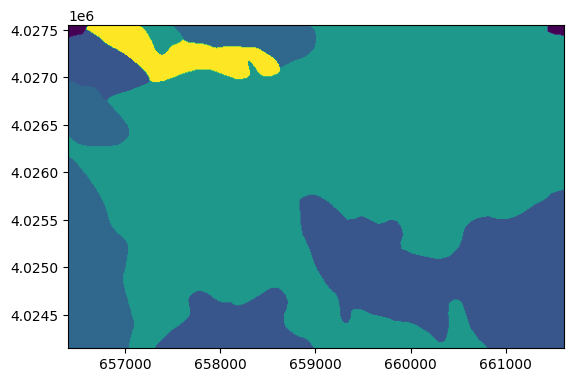

<Axes: >

In [8]:
rst_path='/content/drive/MyDrive/raster_to_be_used/Anafi_rasterized_vector.tif'
from osgeo import gdal
raster = rasterio.open(rst_path)
#raster.RasterCount
show(raster)

In [10]:

# Define the dictionary with pixel values and labels
pixel_dict = labelcreation("/content/drive/MyDrive/LithDatasSHP")
# Set the input folder containing raster files
# define the folder path containing the raster files
input_folder = "/content/drive/MyDrive/raster_to_be_used"
output_folder = "/content/drive/MyDrive/finalrasterdata"
# Function to apply labels based on the dictionary

def apply_labels(raster_data, pixel_dict):
    labeled_data = np.full(raster_data.shape, 0, dtype=np.int32)
    for pixel_value, label in pixel_dict.items():
        labeled_data[raster_data == pixel_value] = pixel_value
    return labeled_data

# Iterate through the files in the folder
for filename in os.listdir(input_folder):
    if filename.endswith(".tif"):  # Assuming your raster files have a .tif extension
        input_file_path = os.path.join(input_folder, filename)
        output_file_path = os.path.join(output_folder, f'labeled_{filename}')

        # Read the raster data
        with rasterio.open(input_file_path) as src:
            raster_data = src.read(1)
            profile = src.profile

        # Apply the labels
        labeled_data = apply_labels(raster_data, pixel_dict)

        # Save the labeled raster data as a GeoTIFF
        with rasterio.open(output_file_path, "w", **profile) as dst:
            dst.write(labeled_data, 1)

        # Save the label information to a text file
        label_file_path = output_file_path.replace(".tif", ".txt")
        with open(label_file_path, "w") as label_file:
            unique_pixel_values = np.unique(labeled_data)
            for pixel_value in unique_pixel_values:
                label = pixel_dict.get(pixel_value, "unknown")
                label_file.write(f"{pixel_value}: {label}\n")

In [11]:
def check_labels(file_path, pixel_dict):
    label_file_path = file_path.replace(".tif", ".txt")

    if not os.path.exists(label_file_path):
        print(f"Label information file not found: {label_file_path}")
        return

    # Read the label information from the text file
    with open(label_file_path, "r") as label_file:
        label_info = {}
        for line in label_file:
            pixel_value, label = line.strip().split(": ")
            label_info[int(pixel_value)] = label

    # Read the raster data with rasterio
    with rasterio.open(file_path) as src:
        raster_data = src.read(1)

    # Check the labels for each pixel value
    for pixel_value, label in pixel_dict.items():
        print(f"Checking label {label} for pixel value {pixel_value}:")
        print("  Expected label:", label)
        print("  Label information file contains the correct label:",
              label_info.get(pixel_value) == label)

# Iterate through the files in the folder
for filename in os.listdir(output_folder):
    if filename.startswith("labeled_") and filename.endswith(".tif"):
        output_file_path = os.path.join(output_folder, filename)
        print(f"Checking labels for {output_file_path}:")
        check_labels(output_file_path, pixel_dict)
        print()


Checking labels for /content/drive/MyDrive/finalrasterdata/labeled_Agios_Georgios_rasterized_vector.tif:
Checking label nan for pixel value 0:
  Expected label: nan
  Label information file contains the correct label: False
Checking label Not available for pixel value 1:
  Expected label: Not available
  Label information file contains the correct label: False
Checking label Psamitikos Flisxis for pixel value 2:
  Expected label: Psamitikos Flisxis
  Label information file contains the correct label: False
Checking label Koites Potamon for pixel value 3:
  Expected label: Koites Potamon
  Label information file contains the correct label: False
Checking label Tritogeneis apotheseis for pixel value 4:
  Expected label: Tritogeneis apotheseis
  Label information file contains the correct label: True
Checking label Konoi Apotheseon for pixel value 5:
  Expected label: Konoi Apotheseon
  Label information file contains the correct label: False
Checking label Kollouvia Flisxi for pixel valu